In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import Booster
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.imputation import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
import random
import matplotlib.pyplot as plt
import re

/Users/thicorfon/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
models_path = './../../Test Models/'
models_suffix = '.model.bin'

In [4]:
models = os.listdir(models_path)
models.remove('.DS_Store')
models = [x[:-10] for x in models]

In [5]:
test_df = pd.read_csv('./../aggregated_test_data.csv')
test_df = test_df[sorted(list(test_df.columns))]
to_drop =  ['Subject','Mag_Z_mean','Mag_X_mean','Mag_Y_mean','Mag_Y_std','Mag_Z_std','Mag_X_std','Contact_size_mean','Pressure_mean','Pressure_std','Contact_size_std']
test_df = test_df.drop(to_drop,axis=1)
test_df = test_df.set_index(["SessionID", 'WindowNumber'])

In [6]:
def find_subject(row):
    reg_pat = r'[a-z]+(([A-Z]|[a-z])+)'
    regex = re.compile(reg_pat)
    s = regex.search(row.SessionID)
    return (s.group(1))

In [7]:
def run_back_test(models_path,models_suffix,models,test_df):
    aux_dict = {}
    print(map_features(test_df.columns))
    for model in models:
        clf = xgb.XGBClassifier(n_estimators=90, max_depth=9, random_state=31, colsample_bytree=0.6, colsample_bylevel=0.5, learning_rate=0.11, subsample=0.9)
        booster = Booster()
        booster.load_model(models_path+model+models_suffix)
        clf._Booster = booster
        print(model)
        xgb.plot_importance(clf)
        aux_dict[model] = pd.DataFrame(clf.predict_proba(test_df)[:, 1], columns=["prob"], index=test_df.index)
    return aux_dict

In [8]:
def run_means(pred_dict,models):
    aux_dict = {}
    for model in models:
        aux_dict[model] = pred_dict[model].reset_index().groupby(['SessionID']).mean()
    return aux_dict

In [9]:
def map_features(features):
    i = 0 
    fmap = {}
    for feature in features:
        fmap['f'+str(i)]=feature
        i+=1
    return fmap

In [33]:
def calculate_auc(mean_dict,models):
    aux_dict = {}
    for model in models:
        threshold = 0
        step = 0.001
        aux_list = []
        model_mean_copy = mean_dict[model].copy()
        all_negatives = len(model_mean_copy[model_mean_copy.Target == 0])
        all_positives = len(model_mean_copy[model_mean_copy.Target == 1])
        while threshold <= 1:
            fp = 0
            tp = 0
            tn = 0
            fn = 0
            for _,row in model_mean_copy.iterrows():
                if row.prob >= threshold and row.Target == 1:
                    tp += 1
                elif row.prob >= threshold and row.Target == 0:
                    fp += 1
                elif row.prob < threshold and row.Target == 0:
                    tn += 1
                elif row.prob < threshold and row.Target == 1:
                    fn += 1
            try:
                fpr = (1.0*fp)/(1.0*all_negatives)
                tpr = (1.0*tp)/(1.0*all_positives)
                acc = 1.0*(tn+tp)/(1.0*(fp+tp+tn+fn))
            except:
                fpr = 0
                tpr = 0
                acc = 0 
            aux_list.append([threshold,fpr,tpr,acc])
            threshold += step
        aux_dict[model] = pd.DataFrame(aux_list,columns=['threshold','FPR','TPR','ACC'])
    return aux_dict

In [42]:
def calculate_f_score(mean_dict,models,threshold,beta):
    aux_dict = {}
    for model in models:
        model_mean_copy = mean_dict[model].copy()
        all_positives = len(model_mean_copy[model_mean_copy.Target == 1])
        tp = 0
        fp = 0
        for _,row in model_mean_copy.iterrows():
            if row.prob >= threshold and row.Target == 1:
                tp += 1
            elif row.prob >= threshold and row.Target == 0:
                fp += 1
        try:
            precision = (1.0*tp)/(1.0*tp + 1.0*fp)
            recall = (1.0*tp)/(1.0*all_positives)
            fscore = ((1+beta*beta)*precision*recall)/((beta*beta*precision)+recall)
        except:
            precision = 0
            recall = 0
            fscore = 0
        aux_dict[model] = {'precision':precision,
                          'recall':recall,
                          'fscore':fscore}
    return aux_dict
            

In [55]:
def calculate_optimum_threshold(mean_dict,models,beta):
    i = 0
    aux_list = []
    thresholds = []
    while i <= 1:
        thresholds.append(i)
        f_score_dict = calculate_f_score(mean_dict,models,i,beta)
        aux_dict = {}
        for model in models:
            aux_dict[model] = f_score_dict[model]['fscore']
        aux_list.append(aux_dict)
        i = i + 0.001
    return thresholds, aux_list
        

{'f0': 'Acc_X_mean', 'f1': 'Acc_X_std', 'f2': 'Acc_Y_mean', 'f3': 'Acc_Y_std', 'f4': 'Acc_Z_mean', 'f5': 'Acc_Z_std', 'f6': 'Deltas_0_mean', 'f7': 'Deltas_0_median', 'f8': 'Deltas_0_std', 'f9': 'Deltas_1_mean', 'f10': 'Deltas_1_median', 'f11': 'Deltas_1_std', 'f12': 'Gyr_X_mean', 'f13': 'Gyr_X_std', 'f14': 'Gyr_Y_mean', 'f15': 'Gyr_Y_std', 'f16': 'Gyr_Z_mean', 'f17': 'Gyr_Z_std', 'f18': 'Press_count'}
Jo
Toto
Diego


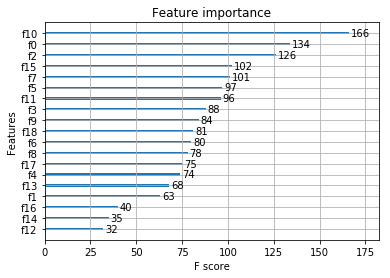

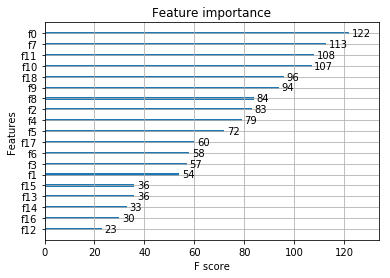

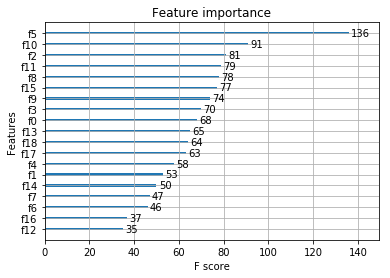

In [36]:
pred_dict = run_back_test(models_path,models_suffix,models,test_df)

In [37]:
mean_dict = run_means(pred_dict,models)

In [38]:
len(mean_dict['Diego'].sort_values('prob',ascending=False))

88

In [39]:
for model in models:
    mean_dict[model]['Subject'] = list(mean_dict[model].reset_index().apply(find_subject,axis=1))
    aux = []
    for _,row in mean_dict[model].iterrows():
        if row.Subject == model:
            aux.append(1)
        else:
            aux.append(0)
    mean_dict[model]['Target'] = aux

In [40]:
for model in models:
    pred_dict[model]['Subject'] = list(pred_dict[model].reset_index().apply(find_subject,axis=1))
    aux = []
    for _,row in pred_dict[model].iterrows():
        if row.Subject == model:
            aux.append(1)
        else:
            aux.append(0)
    pred_dict[model]['Target'] = aux

In [18]:
auc_dict = calculate_auc(mean_dict,models)

In [19]:
auc_pred_dict = calculate_auc(pred_dict,models)

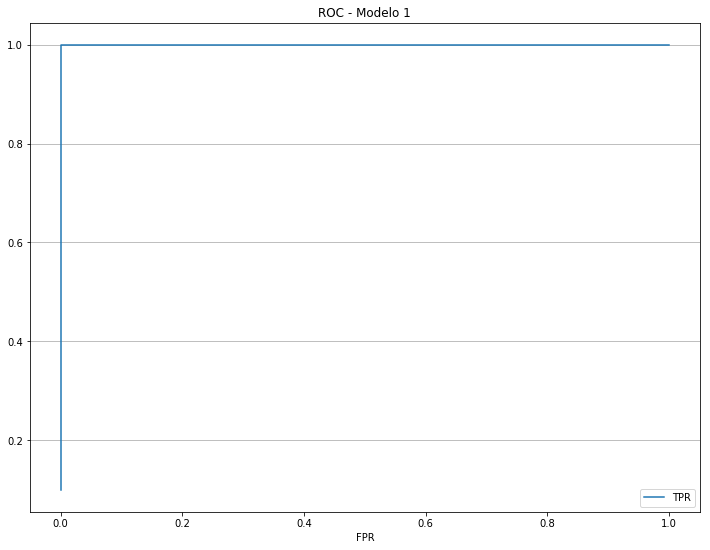

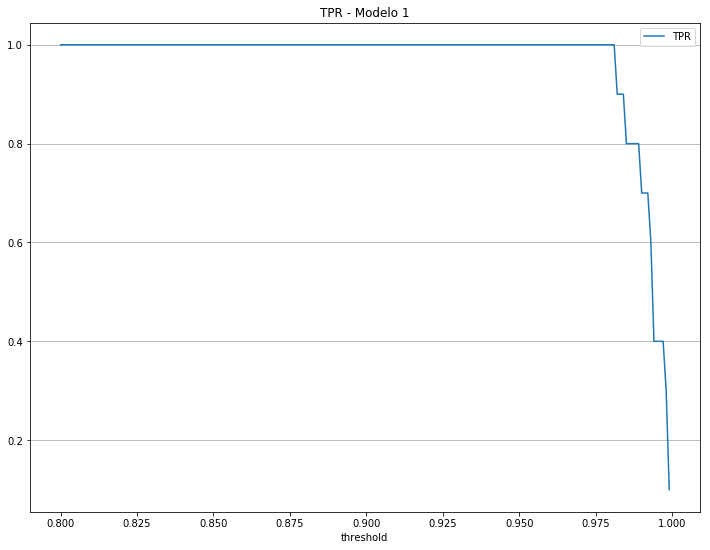

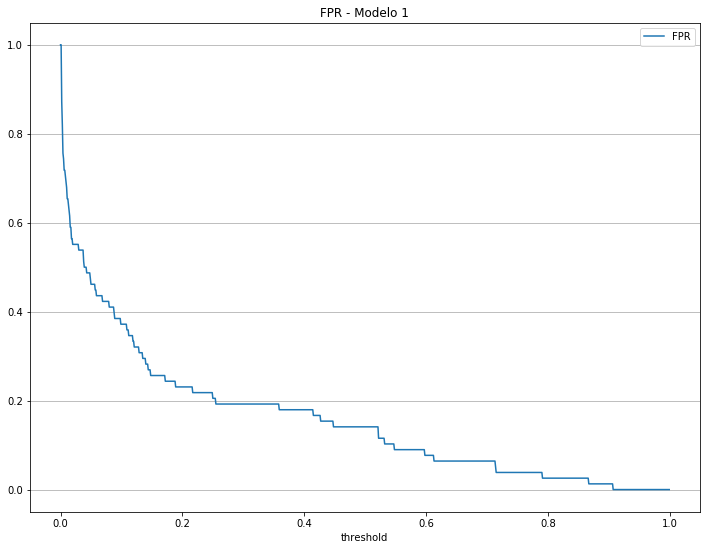

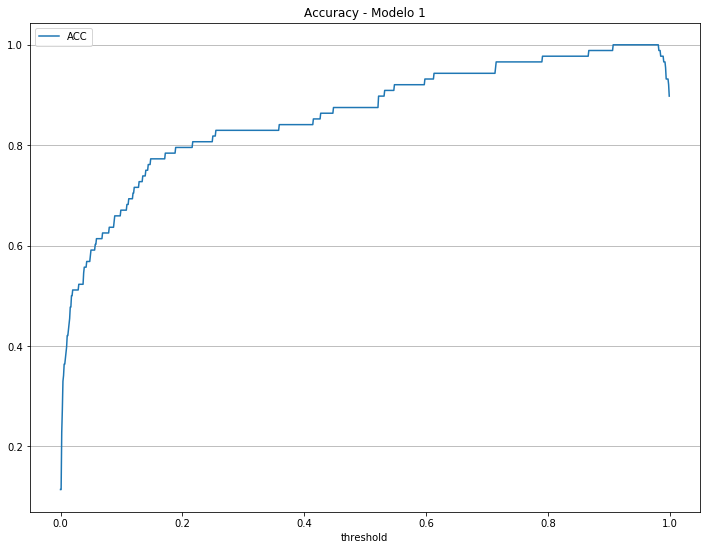

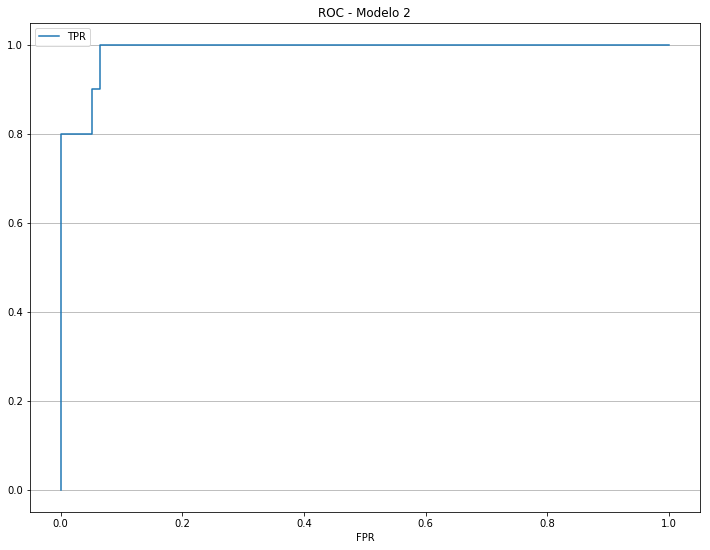

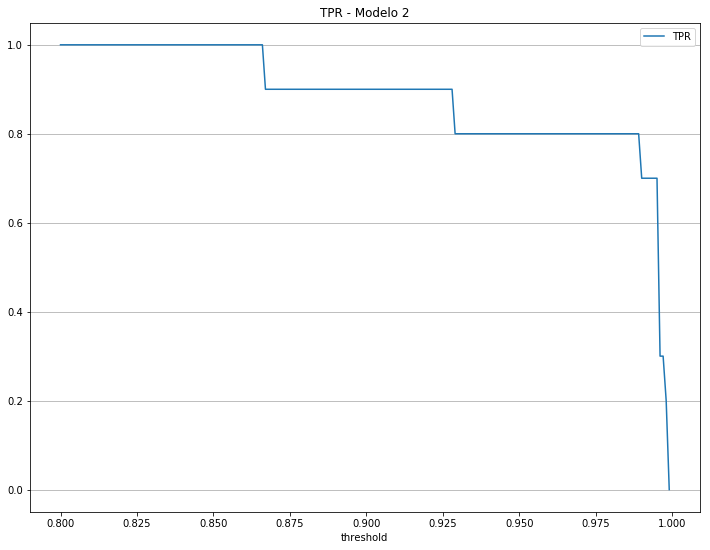

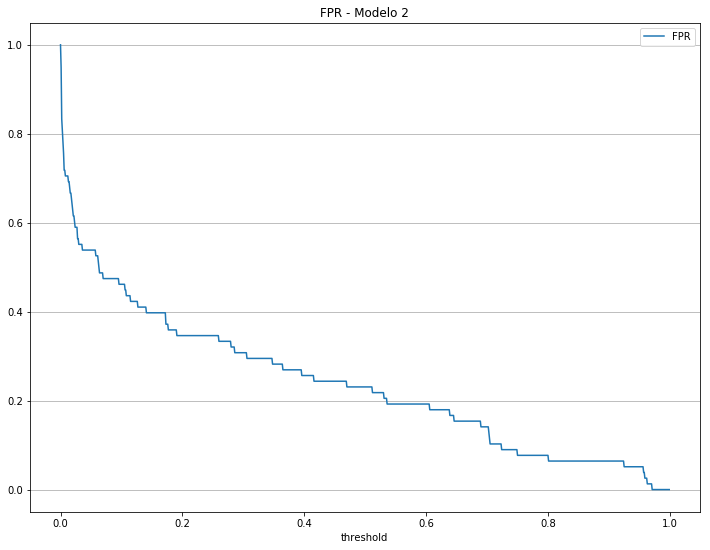

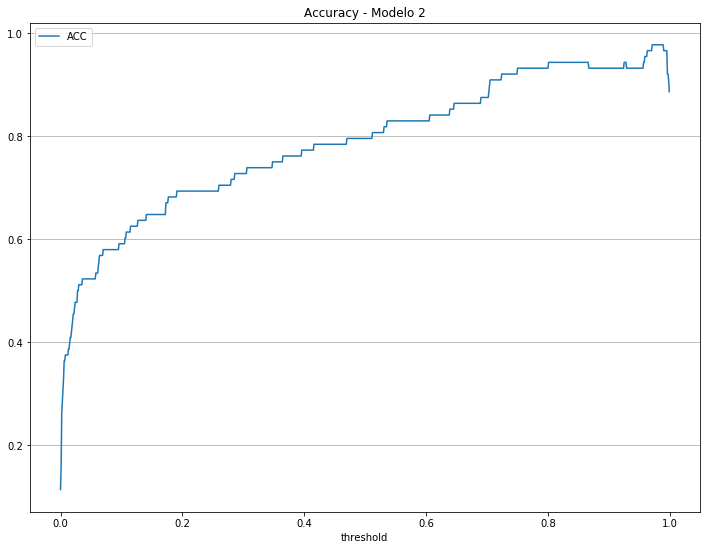

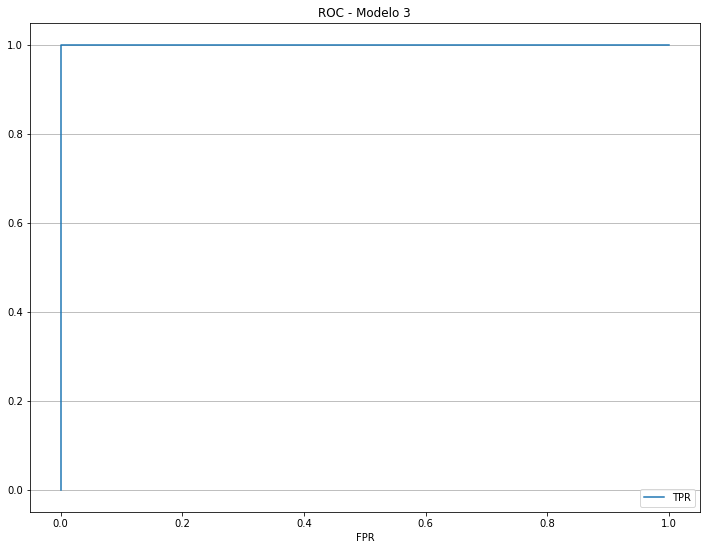

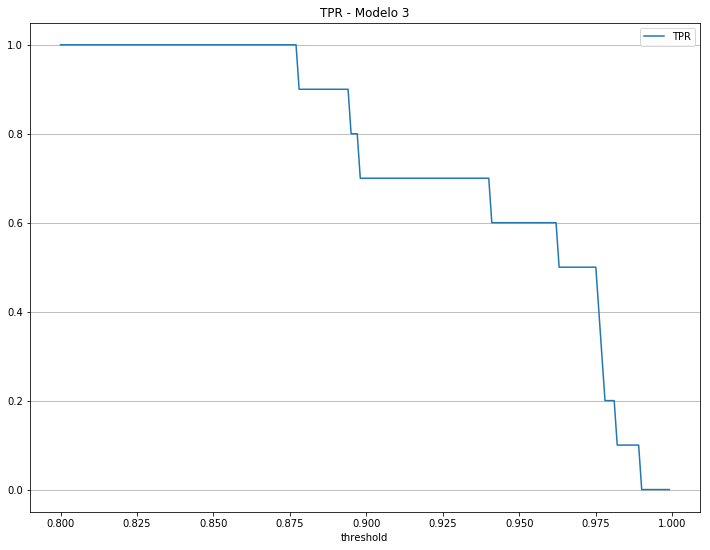

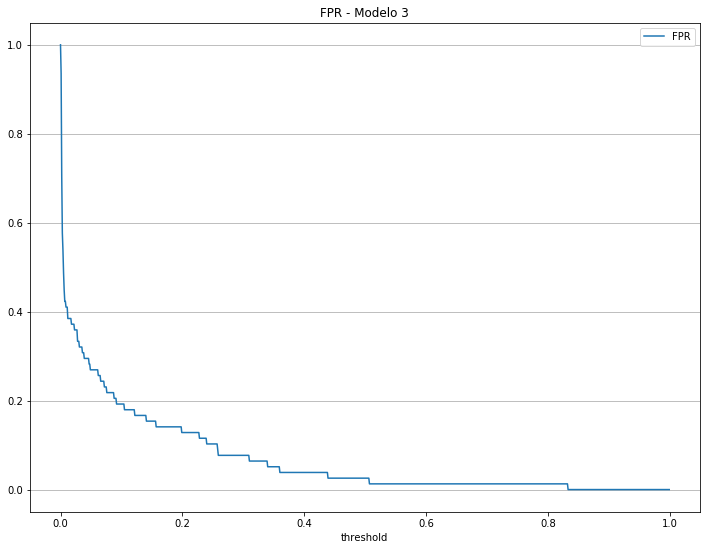

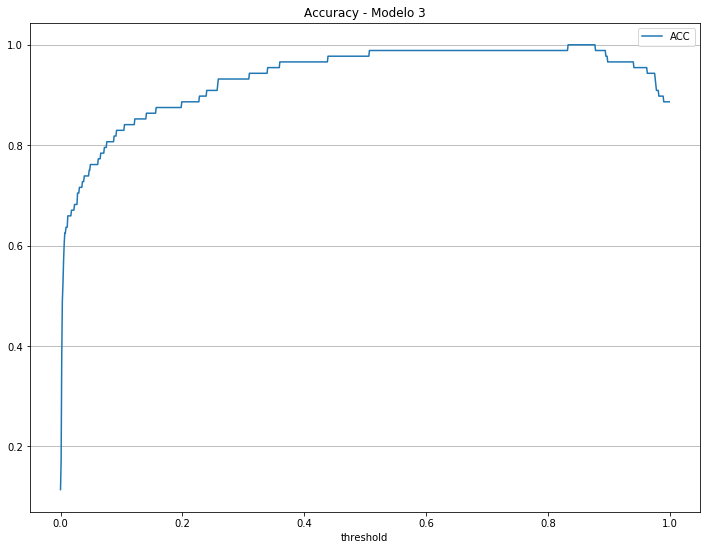

In [20]:
de_para = {'Jo':'Modelo 1','Toto':'Modelo 2','Diego':'Modelo 3'}
for model in models:
    auc_dict[model].plot(x='FPR',y='TPR',figsize = (12,9))
    plt.title('ROC - ' + de_para[model])
    plt.grid(axis='y')
    auc_dict[model][auc_dict[model].threshold >= 0.8].plot(x='threshold',y='TPR',figsize = (12,9))
    plt.title('TPR - ' + de_para[model])
    plt.grid(axis='y')
    auc_dict[model].plot(x='threshold',y='FPR',figsize = (12,9))
    plt.title('FPR - ' + de_para[model])
    plt.grid(axis='y')
    auc_dict[model].plot(x='threshold',y='ACC',figsize = (12,9))
    plt.title('Accuracy - ' + de_para[model])
    plt.grid(axis='y')

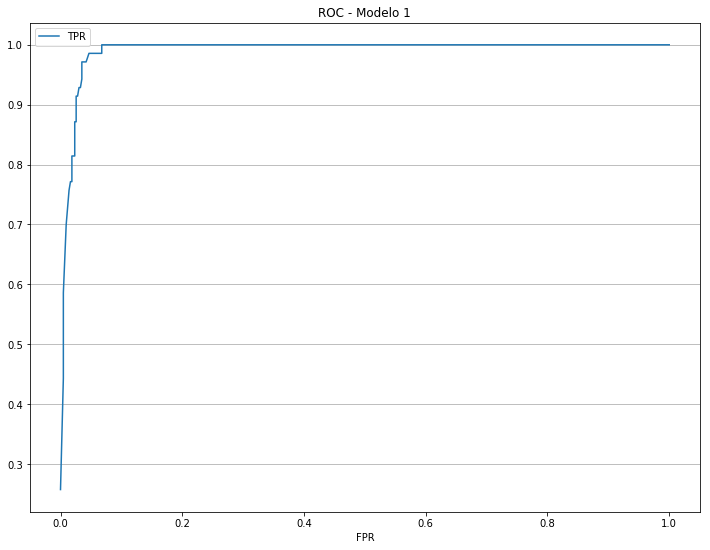

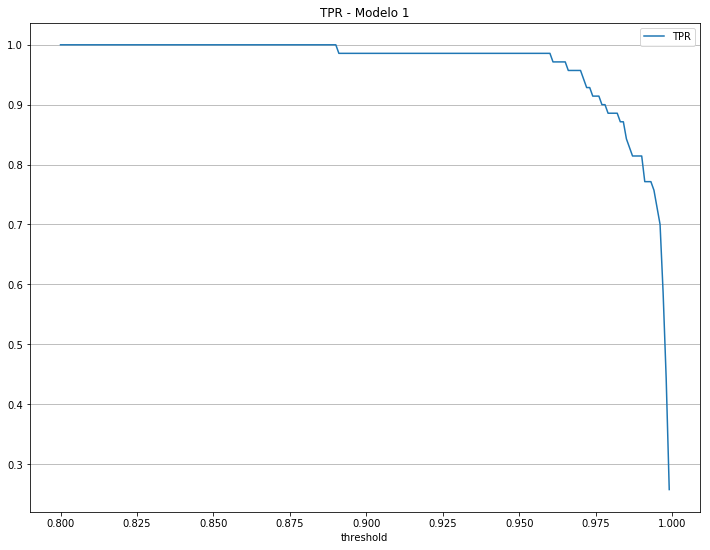

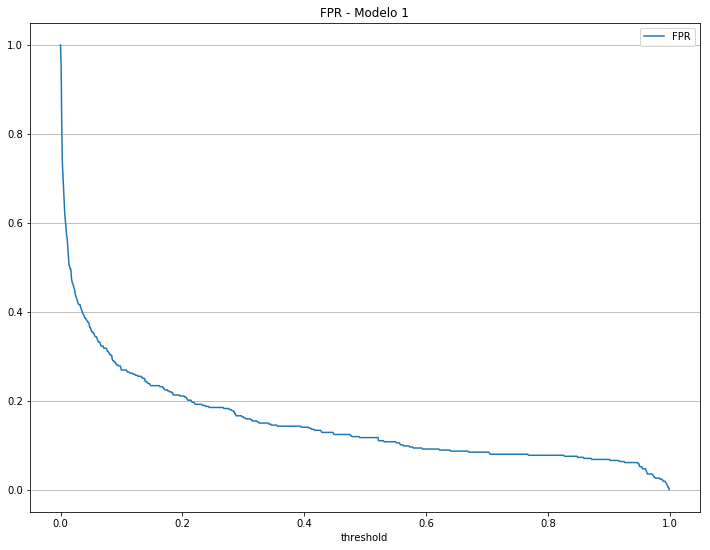

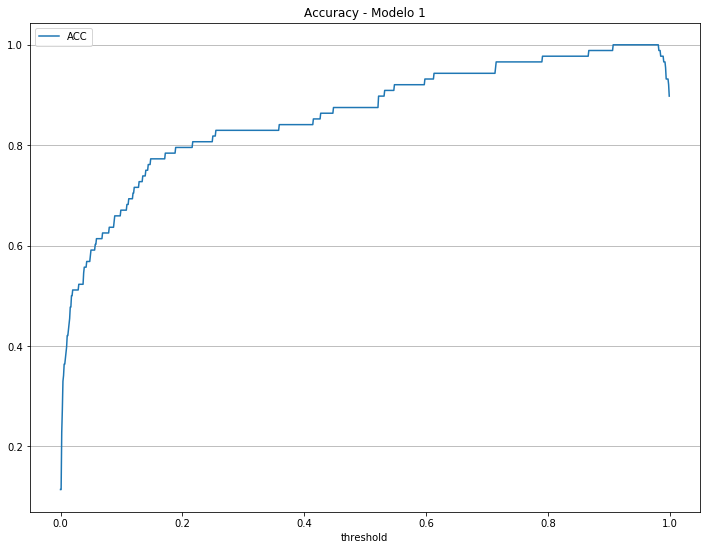

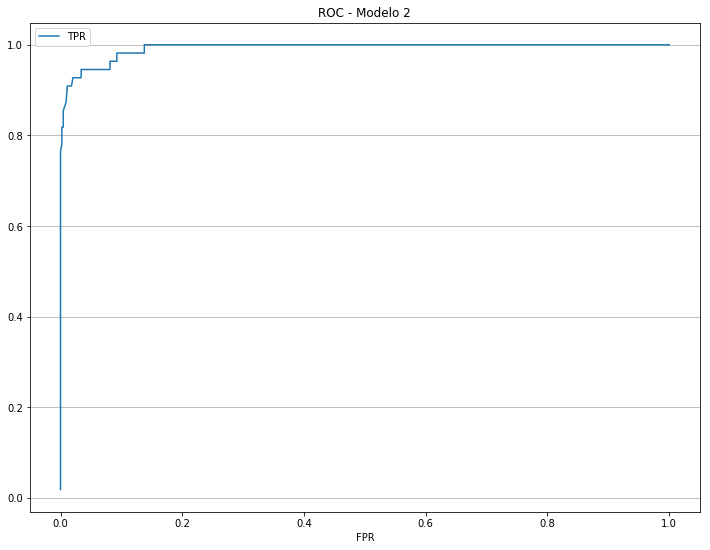

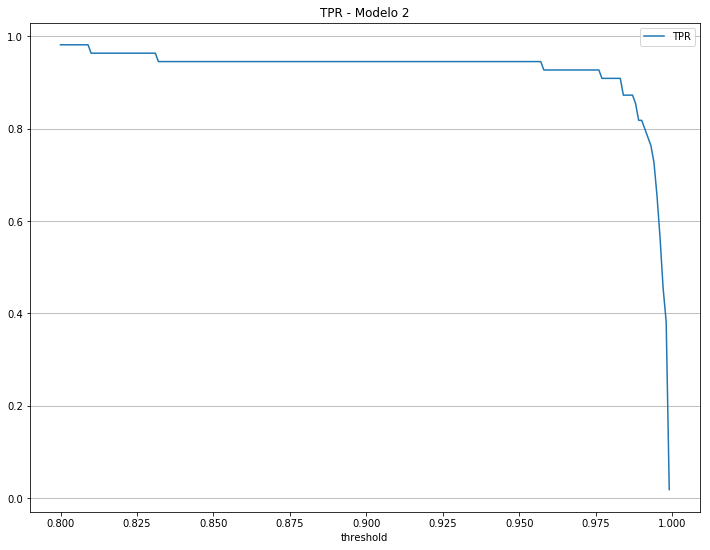

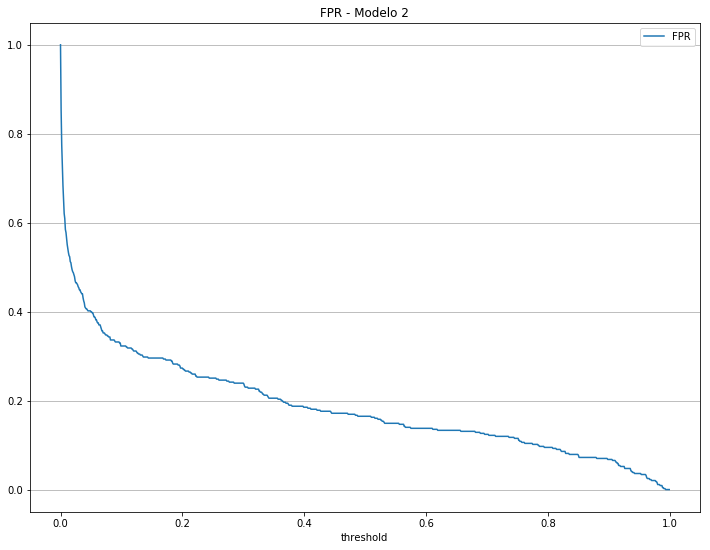

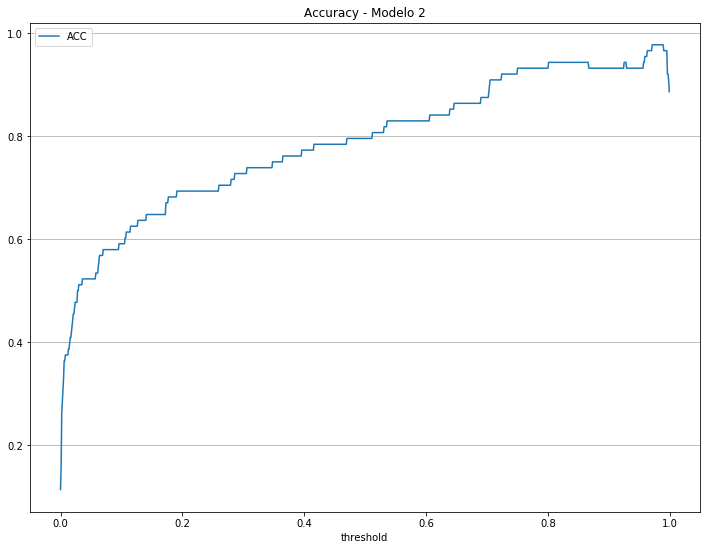

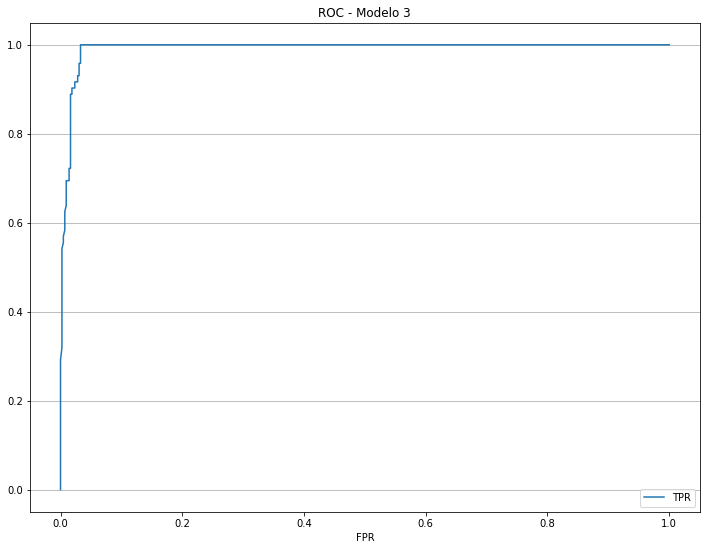

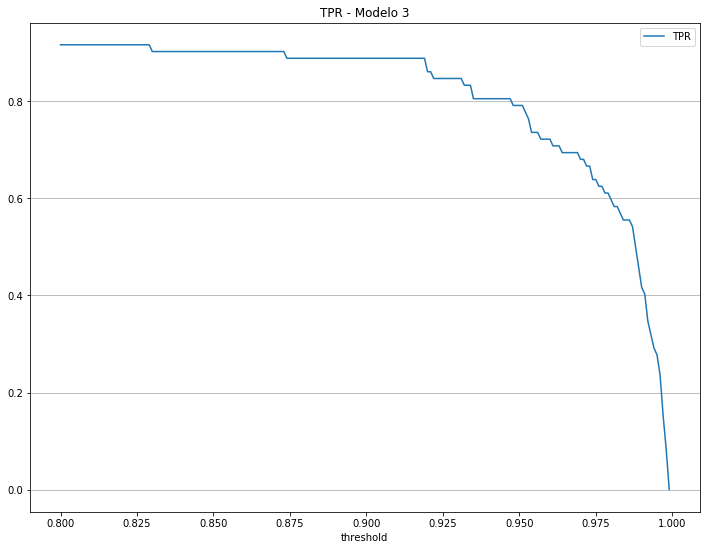

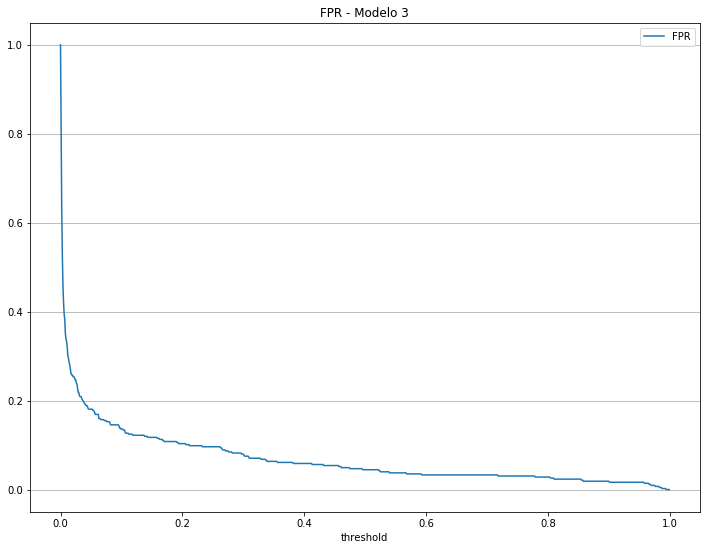

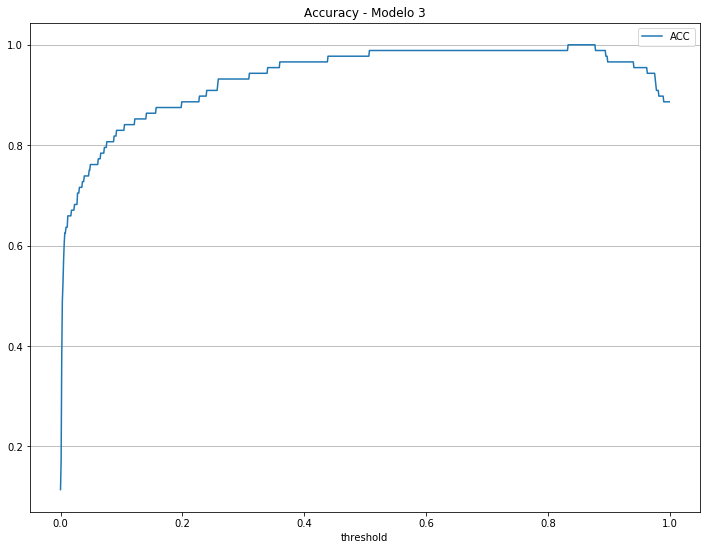

In [21]:
for model in models:
    auc_pred_dict[model].plot(x='FPR',y='TPR',figsize = (12,9))
    plt.title('ROC - ' + de_para[model])
    plt.grid(axis='y')
    auc_pred_dict[model][auc_pred_dict[model].threshold >= 0.8].plot(x='threshold',y='TPR',figsize = (12,9))
    plt.title('TPR - ' + de_para[model])
    plt.grid(axis='y')
    auc_pred_dict[model].plot(x='threshold',y='FPR',figsize = (12,9))
    plt.title('FPR - ' + de_para[model])
    plt.grid(axis='y')
    auc_dict[model].plot(x='threshold',y='ACC',figsize = (12,9))
    plt.title('Accuracy - ' + de_para[model])
    plt.grid(axis='y')

In [22]:
thresholds = {}
lesser_prediction = {}
for model in models:
    thresholds[model] = auc_dict[model][auc_dict[model].FPR == 0].iloc[0].threshold
    lesser_prediction[model] = auc_dict[model][auc_dict[model].TPR != 1.0].iloc[0].threshold

In [23]:
thresholds

{'Jo': 0.90700000000000069,
 'Toto': 0.97100000000000075,
 'Diego': 0.83300000000000063}

In [24]:
lesser_prediction

{'Jo': 0.98200000000000076,
 'Toto': 0.86700000000000066,
 'Diego': 0.87800000000000067}

In [65]:
f1score = calculate_f_score(beta=1,mean_dict=mean_dict,models=models,threshold=0.973)
f2score = calculate_f_score(beta=2,mean_dict=mean_dict,models=models,threshold=0.973)
f05score = calculate_f_score(beta=0.5,mean_dict=mean_dict,models=models,threshold=0.973)

In [ ]:
f05score = calculate_f_score(beta=0.5,mean_dict=mean_dict,models=models,threshold=0.95)

In [56]:
thresholds, fscores = calculate_optimum_threshold(mean_dict,models,beta=0.5)

In [57]:
fscores  = pd.DataFrame(index=thresholds, data=fscores)

In [59]:
for model in models:
    print(fscores.sort_values(by=model,ascending=False).head(1)[[model]])


        Jo
0.916  1.0
           Toto
0.973  0.952381
       Diego
0.833    1.0


In [66]:
f1score

{'Jo': {'precision': 1.0, 'recall': 1.0, 'fscore': 1.0},
 'Toto': {'precision': 1.0, 'recall': 0.8, 'fscore': 0.888888888888889},
 'Diego': {'precision': 1.0, 'recall': 0.5, 'fscore': 0.6666666666666666}}

In [67]:
f2score

{'Jo': {'precision': 1.0, 'recall': 1.0, 'fscore': 1.0},
 'Toto': {'precision': 1.0, 'recall': 0.8, 'fscore': 0.8333333333333334},
 'Diego': {'precision': 1.0, 'recall': 0.5, 'fscore': 0.5555555555555556}}

In [68]:
f05score

{'Jo': {'precision': 1.0, 'recall': 1.0, 'fscore': 1.0},
 'Toto': {'precision': 1.0, 'recall': 0.8, 'fscore': 0.9523809523809523},
 'Diego': {'precision': 1.0, 'recall': 0.5, 'fscore': 0.8333333333333334}}